# Info-HAN Node Classification

# Imports

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
from matplotlib import pyplot as plt
import dgl
import torch as th
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src import model, hgb_data, baseline, evaluate, layers

# Data

## IMDb

### Loading

In [14]:
!wget "https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FIMDB.zip&dl=1" -O ../data/IMDB.zip
!unzip ../data/IMDB.zip -d ../data
!sed -i 's/actorh/actor/g' ../data/IMDB/info.dat

--2023-03-16 16:44:11--  https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FIMDB.zip&dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 166.111.6.101, 2402:f000:1:406:166:111:6:101
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|166.111.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/30d0788b-b526-4b30-a42a-3d006d47f66e/IMDB.zip [following]
--2023-03-16 16:44:12--  https://cloud.tsinghua.edu.cn/seafhttp/files/30d0788b-b526-4b30-a42a-3d006d47f66e/IMDB.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 2102389 (2.0M) [application/zip]
Saving to: ‘../data/IMDB.zip’

../data/IMDB.zip    100%[===================>]   2.00M  1.24MB/s    in 1.6s    

2023-03-16 16:44:14 (1.24 MB/s) - ‘../data/IMDB.zip’ saved [2102389/2102389]

Archive:  ../data/IMDB.zip
   creating: ../data/IMDB/
  inflating: ../data/IMDB/labe

In [2]:
imdb_graph, imdb_labels, imdb_mask = hgb_data.load_graph('../data/IMDB')
imdb_mps = [["md", "dm"], ["ma", "am"]]

### Statistics

In [163]:
imdb_graph

Graph(num_nodes={'actor': 6124, 'director': 2393, 'keyword': 7971, 'movie': 4932},
      num_edges={('actor', 'am', 'movie'): 14779, ('director', 'dm', 'movie'): 4932, ('keyword', 'km', 'movie'): 23610, ('movie', 'ma', 'actor'): 14779, ('movie', 'md', 'director'): 4932, ('movie', 'mk', 'keyword'): 23610},
      metagraph=[('actor', 'movie', 'am'), ('movie', 'actor', 'ma'), ('movie', 'director', 'md'), ('movie', 'keyword', 'mk'), ('director', 'movie', 'dm'), ('keyword', 'movie', 'km')])

In [171]:
for mp in imdb_mps:
    print(mp, dgl.metapath_reachable_graph(imdb_graph, mp).num_edges())

['md', 'dm'] 21282
['ma', 'am'] 99782


## ACM

### Loading

In [15]:
!wget "https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FACM.zip&dl=1" -O ../data/ACM.zip
!unzip ../data/ACM.zip -d ../data

--2023-03-16 16:44:18--  https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FACM.zip&dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 166.111.6.101, 2402:f000:1:406:166:111:6:101
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|166.111.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/46451b7c-876d-4441-a642-4fc7959aa739/ACM.zip [following]
--2023-03-16 16:44:19--  https://cloud.tsinghua.edu.cn/seafhttp/files/46451b7c-876d-4441-a642-4fc7959aa739/ACM.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 4131275 (3.9M) [application/zip]
Saving to: ‘../data/ACM.zip’

../data/ACM.zip     100%[===================>]   3.94M  2.17MB/s    in 1.8s    

2023-03-16 16:44:21 (2.17 MB/s) - ‘../data/ACM.zip’ saved [4131275/4131275]

Archive:  ../data/ACM.zip
   creating: ../data/ACM/
  inflating: ../data/ACM/link.dat    

In [3]:
acm_graph, acm_labels, _ = hgb_data.load_graph('../data/ACM')
acm_mps = [["pa", "ap"], ['ps', 'sp'], 
           ["ref", "pa", "ap"], ['ref', 'ps', 'sp'], 
           ["cite", "pa", "ap"], ["cite", 'ps', 'sp']]

### Statistics

In [164]:
acm_graph

Graph(num_nodes={'author': 5959, 'paper': 3025, 'subject': 56, 'term': 1902},
      num_edges={('author', 'ap', 'paper'): 9949, ('paper', 'cite', 'paper'): 5343, ('paper', 'pa', 'author'): 9949, ('paper', 'ps', 'subject'): 3025, ('paper', 'pt', 'term'): 255619, ('paper', 'ref', 'paper'): 5343, ('subject', 'sp', 'paper'): 3025, ('term', 'tp', 'paper'): 255619},
      metagraph=[('author', 'paper', 'ap'), ('paper', 'paper', 'cite'), ('paper', 'paper', 'ref'), ('paper', 'author', 'pa'), ('paper', 'subject', 'ps'), ('paper', 'term', 'pt'), ('subject', 'paper', 'sp'), ('term', 'paper', 'tp')])

In [172]:
for mp in acm_mps:
    print(mp, dgl.metapath_reachable_graph(acm_graph, mp).num_edges())

['pa', 'ap'] 29767
['ps', 'sp'] 2217089
['ref', 'pa', 'ap'] 52965
['ref', 'ps', 'sp'] 1440299
['cite', 'pa', 'ap'] 70711
['cite', 'ps', 'sp'] 1933761


## DBLP

### Loading

In [16]:
!wget "https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FDBLP.zip&dl=1" -O ../data/DBLP.zip
!unzip ../data/DBLP.zip -d ../data

--2023-03-16 16:44:22--  https://cloud.tsinghua.edu.cn/d/a2728e52cd4943efa389/files/?p=%2FDBLP.zip&dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 166.111.6.101, 2402:f000:1:406:166:111:6:101
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|166.111.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/d9fe4fb3-9b14-43c3-84b6-679552b44dc0/DBLP.zip [following]
--2023-03-16 16:44:23--  https://cloud.tsinghua.edu.cn/seafhttp/files/d9fe4fb3-9b14-43c3-84b6-679552b44dc0/DBLP.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 2567741 (2.4M) [application/zip]
Saving to: ‘../data/DBLP.zip’

../data/DBLP.zip    100%[===================>]   2.45M  1.45MB/s    in 1.7s    

2023-03-16 16:44:25 (1.45 MB/s) - ‘../data/DBLP.zip’ saved [2567741/2567741]

Archive:  ../data/DBLP.zip
   creating: ../data/DBLP/
  inflating: ../data/__MACOSX/

In [4]:
dblp_graph, dblp_labels, _ = hgb_data.load_graph('../data/DBLP')
dblp_mps = [["ap", "pa"], ["ap", "pv", "vp", "pa"], ["ap", "pt", "tp", "pa"]]

### Statistics

In [165]:
dblp_graph

Graph(num_nodes={'author': 4057, 'paper': 14328, 'term': 7723, 'venue': 20},
      num_edges={('author', 'ap', 'paper'): 19645, ('paper', 'pa', 'author'): 19645, ('paper', 'pt', 'term'): 85810, ('paper', 'pv', 'venue'): 14328, ('term', 'tp', 'paper'): 85810, ('venue', 'vp', 'paper'): 14328},
      metagraph=[('author', 'paper', 'ap'), ('paper', 'author', 'pa'), ('paper', 'term', 'pt'), ('paper', 'venue', 'pv'), ('term', 'paper', 'tp'), ('venue', 'paper', 'vp')])

In [173]:
for mp in dblp_mps:
    print(mp, dgl.metapath_reachable_graph(dblp_graph, mp).num_edges())

['ap', 'pa'] 11113
['ap', 'pv', 'vp', 'pa'] 5000495
['ap', 'pt', 'tp', 'pa'] 7043571


## All Datasets

In [5]:
datasets = [(acm_graph, acm_labels),
           (imdb_graph, imdb_labels, imdb_mask),
           (dblp_graph, dblp_labels)]
dataset_names = ('ACM', 'IMDb', 'DBLP')

In [6]:
score_dfs = {}

In [7]:
score_df = pd.read_csv('node_classification_results.csv').drop(columns=['Unnamed: 0', 'Unnamed: 1'])
score_dfs = {method: res for method, res in score_df.groupby(score_df['model'])}

## Analysis

In [82]:
subgraph = dgl.metapath_reachable_graph(acm_graph, ["pa", "ap"]).to_networkx()#.subgraph(range(100))

plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(subgraph, nx.circular_layout(subgraph), node_size=10, node_color=acm_labels)
nx.draw_networkx_edges(subgraph, nx.circular_layout(subgraph), alpha=0.25);

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f46ffa0a7a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f46ffa0a5f0> (for post_execute):


KeyboardInterrupt: 

# Informed Meta Path Attention

In [ ]:
ihans = (model.HAGNN(acm_mps, num_heads = (16,16,16), feat_proj_size=128, semantic_attn_size = 256, 
                    weight_decay= 0.0002, negative_slope=0.1),
         model.HAGNN(imdb_mps, feat_proj_size=64, label_smoothing=0.05, num_heads=(16,16,16), 
                     semantic_attn_size=64),
         model.HAGNN(dblp_mps, num_heads=(8,8,8)))

ihan_scores = evaluate.evaluate_node_classifications(ihans, datasets, dataset_names)

score_dfs['Static Informed Heterogeneous Attention'] = ihan_scores
ihan_scores.groupby(['dataset', 'train_size']).aggregate([np.mean, np.std]).round(4)

In [107]:
ihans = (model.HAGNN(acm_mps, num_layers=1, num_heads = (16,16,16), semantic_attn_size=64, weight_decay=0.0002),
         model.HAGNN(imdb_mps, feat_proj_size=64, label_smoothing=0.05, num_heads=(16,16,16), 
                     semantic_attn_size=64),
         model.HAGNN(dblp_mps, num_heads=(8,8,8)))

ihan_scores = evaluate.evaluate_node_classifications(ihans, datasets, dataset_names)

score_dfs['Static Informed Heterogeneous Attention'] = ihan_scores
ihan_scores.groupby(['dataset', 'train_size']).aggregate([np.mean, np.std]).round(4)

accuracy_score         f1_micro         f1_macro          \
                             mean     std     mean     std     mean     std   
dataset train_size                                                            
ACM     0.3                0.9352  0.0041   0.9352  0.0041   0.9357  0.0041   
DBLP    0.3                0.9351  0.0036   0.9351  0.0036   0.9306  0.0043   
IMDb    0.3                0.3026  0.0149   0.6861  0.0068   0.6553  0.0102   

                   fit time          test time          
                       mean      std      mean     std  
dataset train_size                                      
ACM     0.3         63.7844  12.7864    4.9111  0.6687  
DBLP    0.3         41.8827  11.8838    4.2330  0.5750  
IMDb    0.3          8.6601   0.5558    0.3107  0.0197

## Training Behaviour

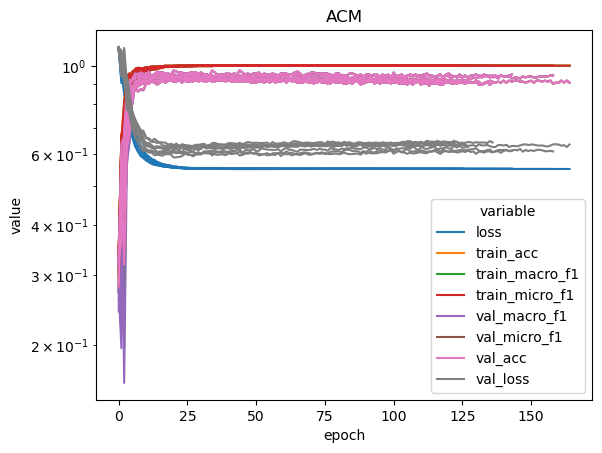

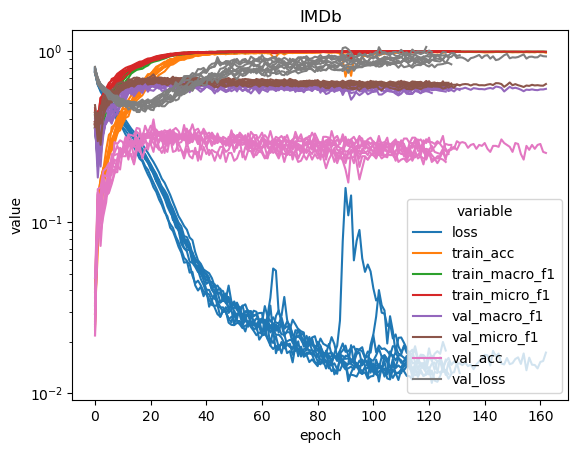

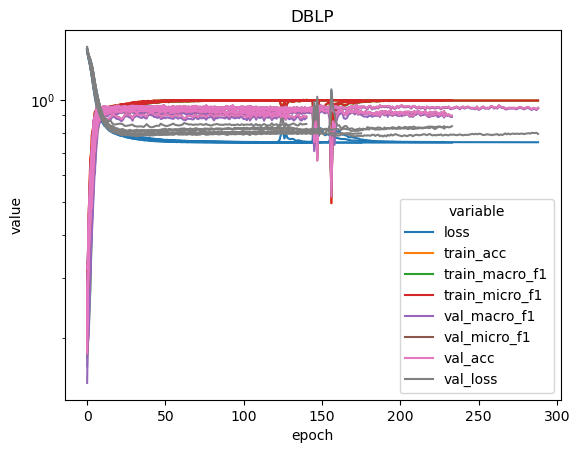

In [112]:
for ihan, name in zip(ihans, dataset_names):
    training_history = pd.DataFrame(ihan.training_history_)
    training_history.melt(id_vars=['epoch', 'run'])
    g_ = sns.lineplot(training_history.melt(id_vars=['epoch', 'run']), x='epoch', y='value', hue='variable',
                     units='run', estimator=None)

    g_.set(yscale='log'), plt.title(name), plt.show()

## Results Table

In [8]:
sota_results = [{'model': 'Simple-HGN', 'dataset': 'DBLP', 
                 'f1_macro' : '94.01$_{\pm0.24}$', 'f1_micro': '94.46$_{\pm0.22}$'},
               {'model': 'Simple-HGN', 'dataset': 'IMDb', 
                'f1_macro' : '63.53$_{\pm1.36}$', 'f1_micro': '67.36$_{\pm0.57}$'},
                {'model': 'Simple-HGN', 'dataset': 'ACM', 
                'f1_macro' : '93.42$_{\pm0.44}$', 'f1_micro': '93.35$_{\pm0.45}$'},
               {'model': 'HAN', 'dataset': 'DBLP', 
                 'f1_macro' : '91.67$_{\pm0.49}$', 'f1_micro': '92.05$_{\pm0.62}$'},
               {'model': 'HAN', 'dataset': 'IMDb', 
                'f1_macro' : '57.74$_{\pm0.96}$', 'f1_micro': '64.63$_{\pm0.58}$'},
                {'model': 'HAN', 'dataset': 'ACM', 
                'f1_macro' : '90.89$_{\pm0.43}$', 'f1_micro': '90.79$_{\pm0.43}$'},
               {'model': 'HGT', 'dataset': 'DBLP', 
                 'f1_macro' : '93.01$_{\pm0.23}$', 'f1_micro': '93.49$_{\pm0.25}$'},
               {'model': 'HGT', 'dataset': 'IMDb', 
                'f1_macro' : '63.00$_{\pm1.19}$', 'f1_micro': '67.20$_{\pm0.57}$'},
               {'model': 'HGT', 'dataset': 'ACM', 
                'f1_macro' : '91.12$_{\pm0.76}$', 'f1_micro': '91.00$_{\pm0.76}$'},
               {'model': 'GAT', 'dataset': 'DBLP', 
                 'f1_macro' : '93.83$_{\pm0.27}$', 'f1_micro': '93.39$_{\pm0.30}$'},
               {'model': 'GAT', 'dataset': 'IMDb', 
                'f1_macro' : '58.94$_{\pm1.35}$', 'f1_micro': '64.86$_{\pm0.43}$'},
               {'model': 'GAT', 'dataset': 'ACM', 
                'f1_macro' : '92.26$_{\pm0.94}$', 'f1_micro': '92.19$_{\pm0.93}$'},
                {'model': 'MAGNN', 'dataset': 'DBLP', 
                 'f1_macro' : '93.28$_{\pm0.51}$', 'f1_micro': '93.76$_{\pm0.45}$'},
               {'model': 'MAGNN', 'dataset': 'IMDb', 
                'f1_macro' : '56.49$_{\pm3.20}$', 'f1_micro': '64.67$_{\pm1.67}$'},
               {'model': 'MAGNN', 'dataset': 'ACM', 
                'f1_macro' : '90.88$_{\pm0.64}$', 'f1_micro': '90.77$_{\pm0.65}$'}]
sota_results = pd.DataFrame(sota_results)
sota_results['Training'] = '0.3'
sota_results = sota_results.melt(id_vars = ['dataset', 'model', 'Training']).rename(columns={'variable':'metric'})

In [178]:
train_size = 0.3
metrics = {'f1_macro' : 'Macro-F1', 'f1_micro' : 'Micro-F1'}
models = {'Static Informed Heterogeneous Attention': 'Info-HAN'}
order = ['GAT', 'HGT', 'Simple-HGN', 'MAGNN', 'HAN', 'Info-HAN']
agg_fun = lambda x: str(round(np.mean(x)*100, 2)) + '$_{\pm' + str(round(np.std(x)*100, 2)) +'}$'

table = score_df[score_df.model.isin(models)].copy().rename(columns={'train_size':'Training'})
table['Training'] = table['Training'].apply(str)
table['model'] = table.model.replace(models)
table = table.melt(id_vars = ['model', 'Training', 'dataset']).rename(columns={'variable':'metric'})

table = table.groupby(['dataset', 'model', 'Training', 'metric']).aggregate(agg_fun).reset_index()
table = pd.concat([table, sota_results], sort=False)

table = table[table.metric.isin(metrics) & (table['Training'] == str(train_size))]
table = table.pivot(columns=['dataset', 'metric'], index='model').value.fillna('-')
table.index.name = None
table = table.loc[order]

best_in_class = (table == table.apply(lambda x: x.max()))
for col in table.columns:
    float_vals = table[col].apply(lambda v: float(v.split('$')[0]))
    best, best_ = float_vals.nlargest(2).index
    table[col][best] = '\\textbf{' + table[col][best] +'}'
    table[col][best_] = '\\textit{' + table[col][best_] +'}'

table_str = table.style.to_latex(column_format='c' + 'l'*len(table.columns), hrules=True)
print(table_str.replace('f1_macro', 'F1\\textsubscript{macro}').replace('f1_micro', 'F1\\textsubscript{micro}'))
table

\begin{tabular}{cllllll}
\toprule
dataset & \multicolumn{2}{r}{ACM} & \multicolumn{2}{r}{DBLP} & \multicolumn{2}{r}{IMDb} \\
metric & F1\textsubscript{macro} & F1\textsubscript{micro} & F1\textsubscript{macro} & F1\textsubscript{micro} & F1\textsubscript{macro} & F1\textsubscript{micro} \\
\midrule
GAT & 92.26$_{\pm0.94}$ & 92.19$_{\pm0.93}$ & \textit{93.83$_{\pm0.27}$} & 93.39$_{\pm0.30}$ & 58.94$_{\pm1.35}$ & 64.86$_{\pm0.43}$ \\
HGT & 91.12$_{\pm0.76}$ & 91.00$_{\pm0.76}$ & 93.01$_{\pm0.23}$ & 93.49$_{\pm0.25}$ & 63.00$_{\pm1.19}$ & 67.20$_{\pm0.57}$ \\
MAGNN & 90.88$_{\pm0.64}$ & 90.77$_{\pm0.65}$ & 93.28$_{\pm0.51}$ & \textit{93.76$_{\pm0.45}$} & 56.49$_{\pm3.20}$ & 64.67$_{\pm1.67}$ \\
Simple-HGN & \textit{93.42$_{\pm0.44}$} & \textit{93.35$_{\pm0.45}$} & \textbf{94.01$_{\pm0.24}$} & \textbf{94.46$_{\pm0.22}$} & 63.53$_{\pm1.36}$ & 67.36$_{\pm0.57}$ \\
HAN & 90.89$_{\pm0.43}$ & 90.79$_{\pm0.43}$ & 91.67$_{\pm0.49}$ & 92.05$_{\pm0.62}$ & 57.74$_{\pm0.96}$ & 64.63$_{\pm0.58}$ \\
Re

dataset                            ACM                              \
metric                        f1_macro                    f1_micro   
GAT                  92.26$_{\pm0.94}$           92.19$_{\pm0.93}$   
HGT                  91.12$_{\pm0.76}$           91.00$_{\pm0.76}$   
MAGNN                90.88$_{\pm0.64}$           90.77$_{\pm0.65}$   
Simple-HGN  \textit{93.42$_{\pm0.44}$}  \textit{93.35$_{\pm0.45}$}   
HAN                  90.89$_{\pm0.43}$           90.79$_{\pm0.43}$   
Res-HAN              92.66$_{\pm0.32}$           92.61$_{\pm0.32}$   
SHAN                  91.7$_{\pm0.59}$           91.68$_{\pm0.58}$   
Info-HAN    \textbf{93.56$_{\pm0.45}$}   \textbf{93.5$_{\pm0.45}$}   

dataset                           DBLP                              \
metric                        f1_macro                    f1_micro   
GAT         \textit{93.83$_{\pm0.27}$}           93.39$_{\pm0.30}$   
HGT                  93.01$_{\pm0.23}$           93.49$_{\pm0.25}$   
MAGNN                93.28$_{\pm0.51}$  \textit{93.76$_{\pm0.45}$}   
Simple-HGN  \textbf{94.01$_{\pm0.24}$}  \textbf{94.46$_{\pm0.22}$}   
HAN                  91.67$_{\pm0.49}$           92.05$_{\pm0.62}$   
Res-HAN              92.91$_{\pm0.41}$           93.38$_{\pm0.36}$   
SHAN                 92.47$_{\pm0.69}$            92.97$_{\pm0.6}$   
Info-HAN             93.29$_{\pm0.44}$           93.71$_{\pm0.38}$   

dataset                           IMDb                              
metric                        f1_macro                    f1_micro  
GAT                  58.94$_{\pm1.35}$           64.86$_{\pm0.43}$  
HGT                  63.00$_{\pm1.19}$           67.20$_{\pm0.57}$  
MAGNN                56.49$_{\pm3.20}$           64.67$_{\pm1.67}$  
Simple-HGN           63.53$_{\pm1.36}$           67.36$_{\pm0.57}$  
HAN                  57.74$_{\pm0.96}$           64.63$_{\pm0.58}$  
Res-HAN     \textit{63.76$_{\pm1.47}$}   \textit{67.99$_{\pm1.0}$}  
SHAN                  61.9$_{\pm1.26}$           67.21$_{\pm0.78}$  
Info-HAN     \textbf{65.77$_{\pm0.7}$}  \textbf{68.77$_{\pm0.63}$}